In [1]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from venn import venn

In [2]:
PATH = "/app/_data/"
BATCH_SIZE = 128
SEED = 42
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 12
INPUT_SIZE = (224, 224, 3)

In [3]:
labels = pd.read_csv(PATH + "train_labels.csv")
sample_submission = pd.read_csv(PATH + "sample_submission.csv")

In [4]:
sample_submission

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [5]:
labels.head()
labels.info()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18500 entries, 0 to 18499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18500 non-null  object
 1   labels  18500 non-null  object
dtypes: object(2)
memory usage: 289.2+ KB


In [6]:
labels["labels"] = labels["labels"].astype('category')

In [7]:
labels['classes'] = labels["labels"].cat.codes

In [8]:
labels["labels"].value_counts(normalize=True)

scab                               0.259946
healthy                            0.248865
frog_eye_leaf_spot                 0.171622
rust                               0.097946
complex                            0.085243
powdery_mildew                     0.063784
scab frog_eye_leaf_spot            0.036865
scab frog_eye_leaf_spot complex    0.010811
frog_eye_leaf_spot complex         0.008919
rust frog_eye_leaf_spot            0.006378
rust complex                       0.004919
powdery_mildew complex             0.004703
Name: labels, dtype: float64

## resizing and saving images

In [9]:
# def resize_im(
#     image_name, new_folder_name="666_bicubic", size=(666, 666), resample=Image.BICUBIC
# ):
#     image = Image.open(PATH + "train_images/" + image_name)
#     image = image.resize(size, resample=resample)
#     if not os.path.isdir(PATH + "train_images/" + new_folder_name + "/"):
#         os.mkdir(PATH + "train_images/" + new_folder_name + "/")
#     image.save(PATH + "train_images/" + new_folder_name + "/" + image_name)
# labels['image'].apply(resize_im)

## weights

In [10]:
# labels["multi_label"] = labels["labels"].astype("category").cat.codes
# dict_weights = (
#     1
#     / labels["multi_label"].value_counts()
#     / np.sum(1 / labels["multi_label"].value_counts())
# ).to_dict()
# def weight_fill(x):
#    return dict_weights[x]
# labels['weights'] = labels["multi_label"].apply(weight_fill)

## ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    brightness_range=(0.5, 1.5),
    shear_range=45,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
)
train = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=PATH + "train_images/small_bicubic/",
    x_col="image",
    y_col="labels",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    seed=SEED,
    interpolation="bicubic",
)

Found 14800 validated image filenames belonging to 12 classes.


In [12]:
train.class_indices

{'complex': 0,
 'frog_eye_leaf_spot': 1,
 'frog_eye_leaf_spot complex': 2,
 'healthy': 3,
 'powdery_mildew': 4,
 'powdery_mildew complex': 5,
 'rust': 6,
 'rust complex': 7,
 'rust frog_eye_leaf_spot': 8,
 'scab': 9,
 'scab frog_eye_leaf_spot': 10,
 'scab frog_eye_leaf_spot complex': 11}

In [13]:
valid_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255,
)
valid = valid_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=PATH + "train_images/small_bicubic/",
    x_col="image",
    y_col="labels",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    seed=SEED,
    interpolation="bicubic",
)

Found 3700 validated image filenames belonging to 12 classes.


In [14]:
train.class_indices

{'complex': 0,
 'frog_eye_leaf_spot': 1,
 'frog_eye_leaf_spot complex': 2,
 'healthy': 3,
 'powdery_mildew': 4,
 'powdery_mildew complex': 5,
 'rust': 6,
 'rust complex': 7,
 'rust frog_eye_leaf_spot': 8,
 'scab': 9,
 'scab frog_eye_leaf_spot': 10,
 'scab frog_eye_leaf_spot complex': 11}

In [15]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH + "test_images/",
    x_col="image",
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    seed=SEED,
    shuffle=False,
    interpolation="bicubic",
)

Found 3 validated image filenames.


### plots

In [16]:
def plot_curves(model, loss=False):
    df = pd.DataFrame(model.history)
    if loss:
        plt.figure(figsize=(12, 6))
        plt.title("loss")
        plt.plot(df.iloc[:, 0], label="loss")
        plt.plot(df.iloc[:, 5], label="val_loss")
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(12, 20))
        plt.subplot(4, 1, 1)
        plt.title("accuracy")
        plt.plot(df.iloc[:, 1], label="accuracy")
        plt.plot(df.iloc[:, 6], label="val_accuracy")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.title("recall")
        plt.plot(df.iloc[:, 2], label="recall")
        plt.plot(df.iloc[:, 7], label="val_recall")
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.title("precision")
        plt.plot(df.iloc[:, 3], label="precision")
        plt.plot(df.iloc[:, 8], label="val_precision")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.title("f1")
        plt.plot(df.iloc[:, 4], label="f1")
        plt.plot(df.iloc[:, 9], label="val_f1")
        plt.legend()
        plt.show();

## model

### from keras
<https://keras.io/guides/preprocessing_layers/#image-preprocessing-layers>

In [17]:
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        keras.layers.experimental.preprocessing.RandomHeight(0.1),
        keras.layers.experimental.preprocessing.RandomWidth(0.1),
        keras.layers.experimental.preprocessing.RandomRotation(0.15),
        keras.layers.experimental.preprocessing.RandomZoom(0.25, 0.25),
    ]
)

### func style

In [ ]:
policy = keras.mixed_precision.experimental.Policy('mixed_float16')
keras.mixed_precision.experimental.set_policy(policy)

In [18]:
inputs = keras.Input(shape=INPUT_SIZE)
x = keras.applications.ResNet50(weights="imagenet", include_top=False)(inputs)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Flatten(name="flatten")(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [32]:
def scheduler(epoch, lr):
#     if epoch < 5:
#         return 0.001
#     elif 5 <= epoch <35:
#         return 0.0005
#     else:
        return 0.0001

In [34]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="loss", patience=10, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/resnet50_12cl_100eps.h5",
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="auto",
        save_freq="epoch",
    ),
    keras.callbacks.LearningRateScheduler(schedule = scheduler, verbose=1)
]

In [21]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(lr=0.0005),
    metrics=[
        "acc",
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=1, average="micro"),
    ],
)

In [22]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                24588     
Total params: 23,612,300
Trainable params: 23,559,180
Non-trainable params: 53,120
_________________________________________________________________


In [35]:
history = model.fit(
    train,
    validation_data=valid,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    callbacks=callbacks,
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/50
116/116 [==============================] - 203s 2s/step - loss: 0.1579 - acc: 0.9438 - recall: 0.9322 - precision: 0.9567 - f1_score: 0.9438 - val_loss: 0.4469 - val_acc: 0.8851 - val_recall: 0.8784 - val_precision: 0.8926 - val_f1_score: 0.8851

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/50
116/116 [==============================] - 206s 2s/step - loss: 0.1597 - acc: 0.9437 - recall: 0.9320 - precision: 0.9570 - f1_score: 0.9437 - val_loss: 0.5149 - val_acc: 0.8816 - val_recall: 0.8778 - val_precision: 0.8877 - val_f1_score: 0.8816

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 3/50
116/116 [==============================] - 210s 2s/step - loss: 0.1531 - acc: 0.9469 - recall: 0.9368 - precision: 0.9583 - f1_score: 0.9469 - val_loss: 0.4213 - val_acc: 0.8949 - val_recall: 0.8892 - val_precision: 0.9021 - val_f1_score: 0.8949

Epoch 00004: Learn

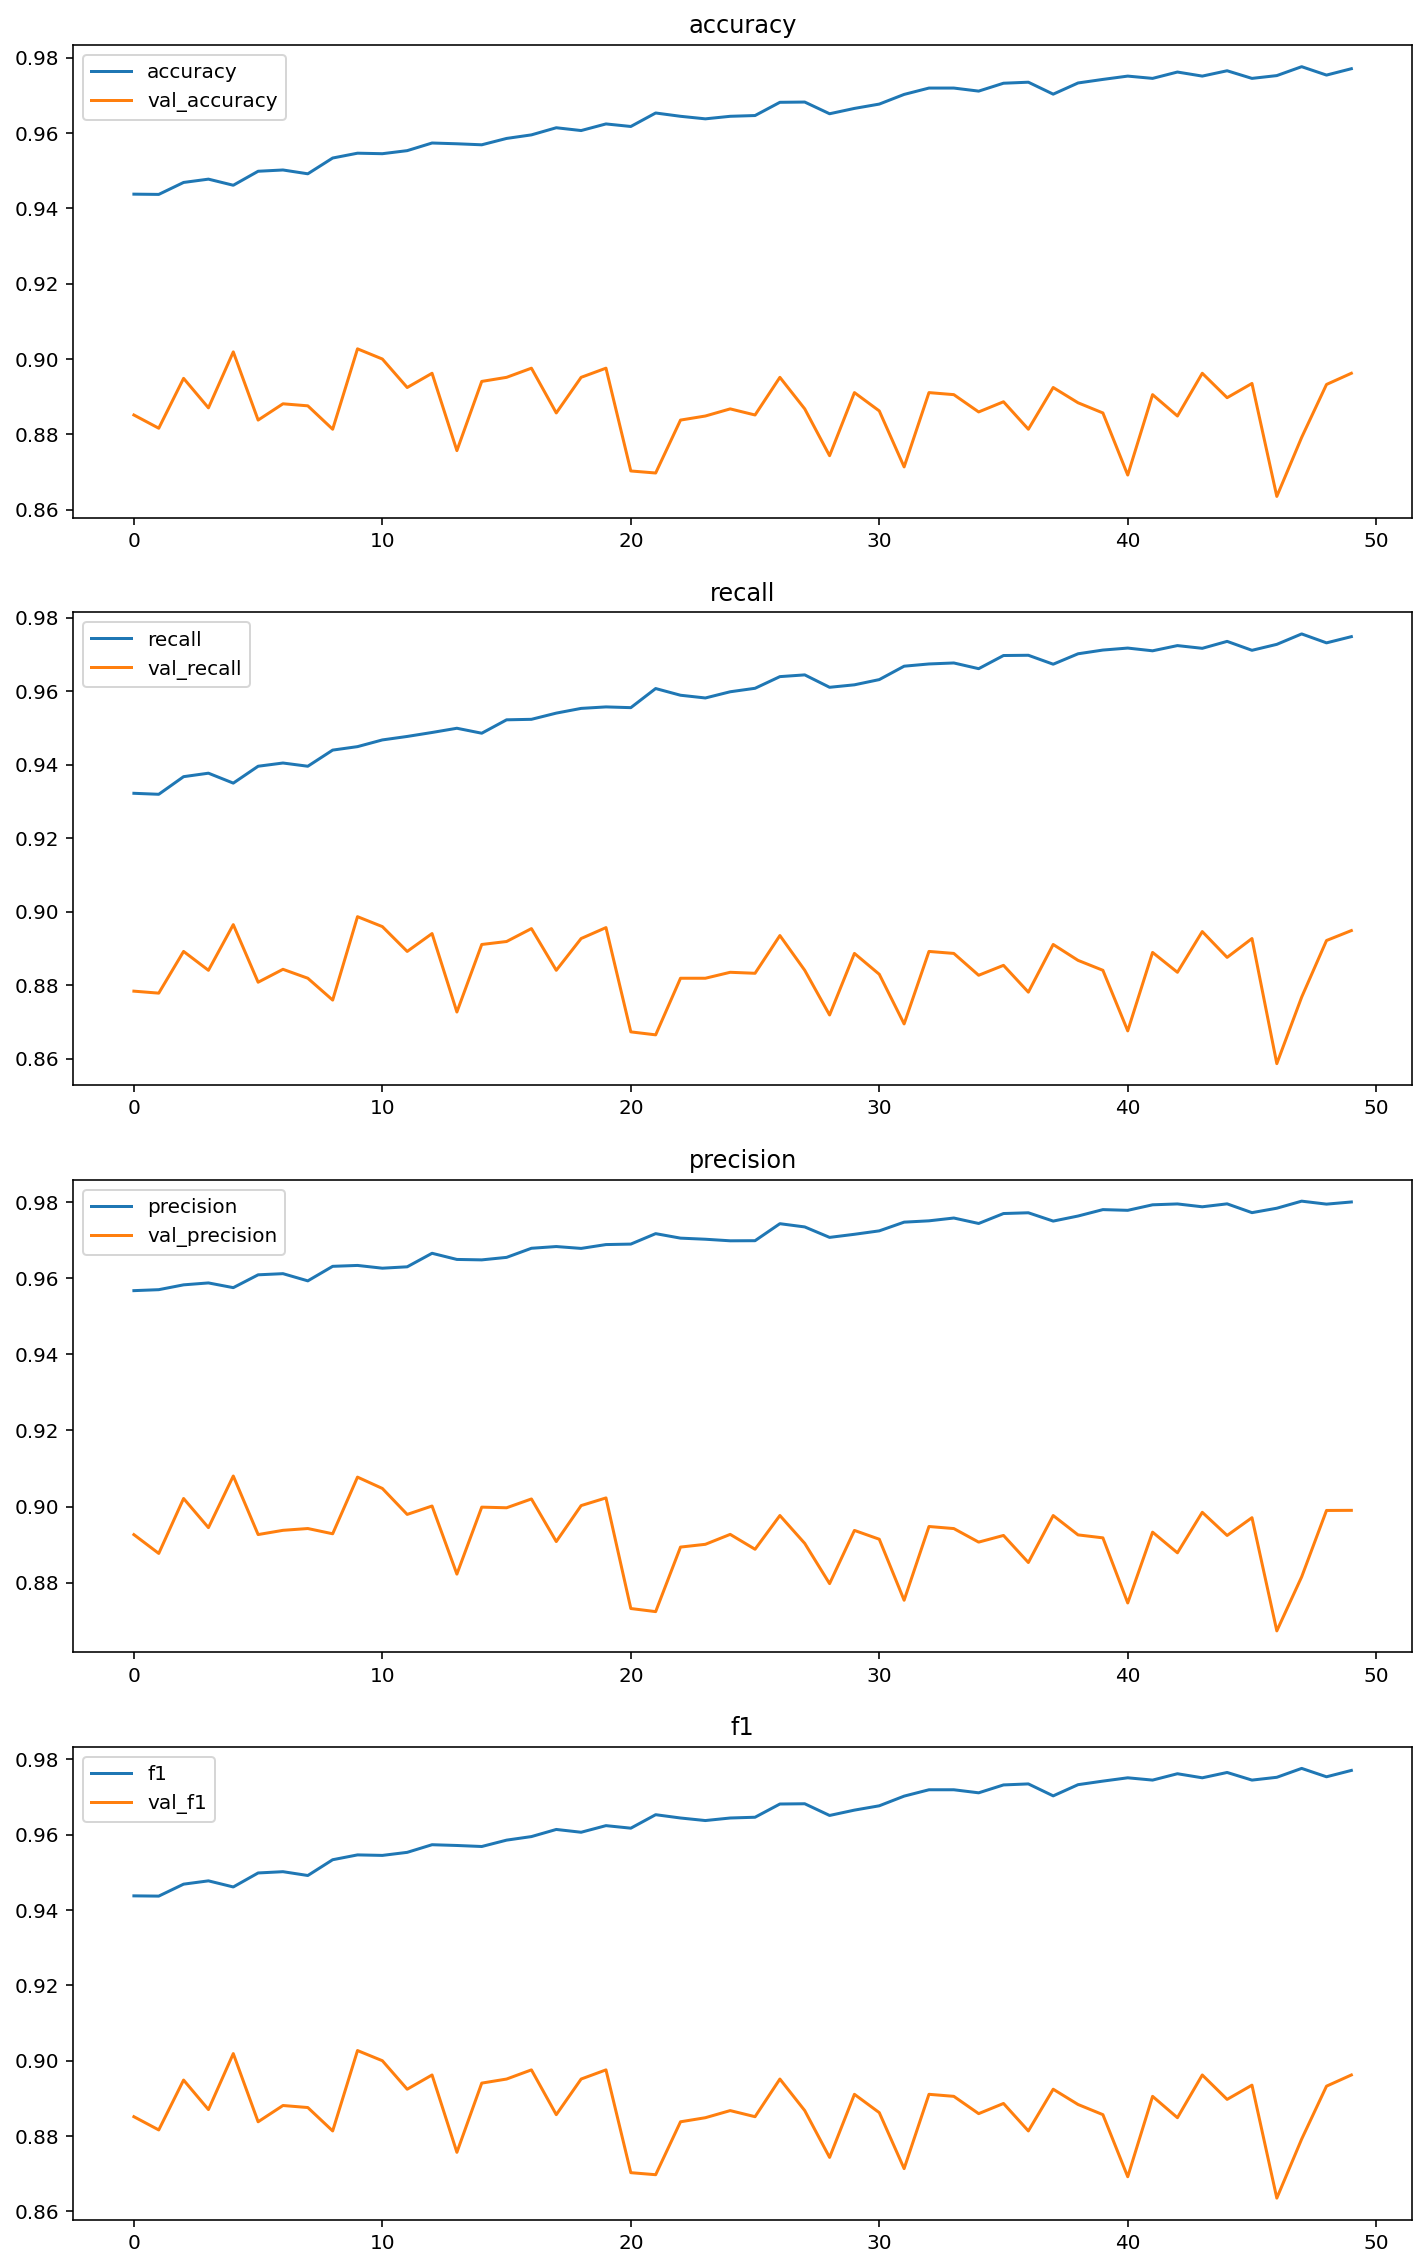

In [37]:
plot_curves(history)

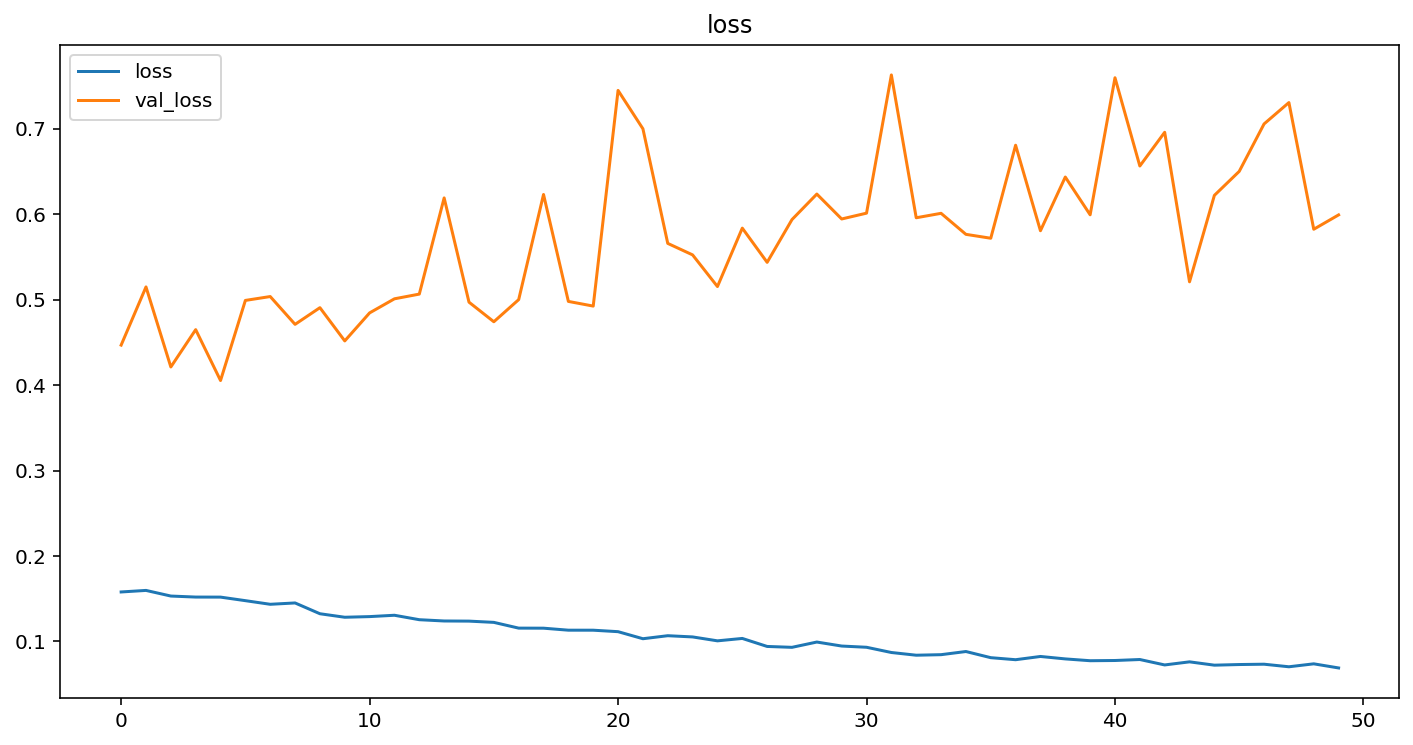

In [38]:
plot_curves(history, loss=True)

In [36]:
model.save("/app/_data/models/resnet50_12cl_100epochs.h5")

In [39]:
def get_prediction(all_img=False):
    if all_img:
        all_img = ImageDataGenerator(rescale=1.0 / 255).flow_from_dataframe(
        dataframe=labels,
        directory=PATH + "train_images/small_bicubic/",
        x_col="image",
        y_col="labels",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        seed=SEED,
        interpolation="bicubic",
        shuffle=False,
        )
        prediction_all = model.predict(all_img)
        prediction = pd.DataFrame(prediction_all).join(
            pd.DataFrame(all_img.labels),
            rsuffix="_true",
            lsuffix="_pred",
        )
        prediction.index = all_img.filenames
    return prediction_all, prediction

In [40]:
pred_all = get_prediction(all_img=True)
# pred_all.to_csv('/app/sandbox/wrong_predictions/prediction_raw_1.csv')

Found 18500 validated image filenames belonging to 12 classes.


In [41]:
pred_all[1].to_csv('/app/sandbox/wrong_predictions/prediction_12cl_raw_2.csv')

In [42]:
pred_all[1]

,0_pred,1,2,3,4,5,6,7,8,9,10,11,0_true
800113bb65efe69e.jpg,1.253175e-03,6.628278e-06,6.312384e-09,5.987754e-01,3.999333e-01,1.464049e-06,2.642071e-05,1.032935e-08,8.614641e-08,3.116516e-06,3.340919e-07,1.121364e-07,3
8002cb321f8bfcdf.jpg,9.961377e-01,3.714062e-08,2.056198e-06,3.792887e-24,1.861735e-13,7.553431e-14,7.111652e-12,2.538108e-07,3.173592e-10,7.327942e-13,2.933527e-03,9.264825e-04,11
80070f7fb5e2ccaa.jpg,3.474167e-09,2.711624e-14,1.149047e-11,3.913469e-18,1.660673e-19,1.623964e-17,4.998577e-12,1.869914e-12,1.408196e-13,1.000000e+00,9.339240e-10,4.657000e-16,9
80077517781fb94f.jpg,3.459475e-08,6.496083e-09,2.666728e-10,4.831219e-09,3.820294e-12,7.647695e-15,5.792253e-10,1.216495e-12,7.328671e-11,9.999919e-01,8.114102e-06,5.361027e-10,9
800cbf0ff87721f8.jpg,9.810615e-01,1.292629e-07,5.981604e-13,2.187480e-26,2.900669e-21,2.888223e-15,1.294307e-16,1.560168e-13,8.188896e-14,4.321269e-16,1.870474e-02,2.337154e-04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffb900a92289a33.jpg,8.411052e-10,5.113451e-08,2.032017e-15,9.999988e-01,7.770794e-14,7.832062e-16,4.706194e-09,2.024996e-14,1.556583e-10,1.170378e-06,1.574795e-11,1.010182e-16,3
fffc488fa4c0e80c.jpg,4.459124e-11,6.734474e-10,5.036449e-17,2.678744e-13,9.436205e-11,2.035197e-16,2.299951e-13,1.251914e-15,4.801342e-17,9.999992e-01,8.093043e-07,5.049120e-08,9
fffc94e092a59086.jpg,6.001681e-07,2.627560e-16,7.161868e-18,5.770002e-17,3.534383e-14,1.007030e-19,9.999994e-01,7.792826e-10,6.175239e-09,5.402021e-14,2.597831e-15,5.221587e-14,6
fffe105cf6808292.jpg,7.505464e-04,1.988309e-04,2.053817e-08,1.147196e-14,3.812400e-15,4.565887e-10,3.813912e-08,1.252989e-13,3.266439e-12,1.411000e-02,9.812703e-01,3.670416e-03,10


## test

In [ ]:
prediction = model.predict(test) > 0.5

In [ ]:
test_sub = pd.DataFrame(prediction, columns=feature_columns)
for name in test_sub.columns.tolist():
    test_sub[name] = test_sub[name].replace({True: name, False: ""})
test_sub["all"] = test_sub.apply(" ".join, axis=1).str.split().str.join(sep=" ")
test_sub.to_csv("app/sandbox/test_sub.csv")

In [ ]:
backbone = ResNet50(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=6, activation="sigmoid"))
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.0001),
    metrics=[
        keras.metrics.CategoricalAccuracy(),
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=6, average="micro"),
    ],
)

In [ ]:
history = model.fit(
    train,
    validation_data=valid,
    epochs=3,
    batch_size=BATCH_SIZE,
    #     steps_per_epoch=64,
    #     validation_steps=16,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
model_l = keras.models.load_model("/app/_data/models/base_model")

In [ ]:
a = model_l.predict(valid)

In [ ]:
a[0]